In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import os

# Preprocessing

In [11]:
def binarize(img):
    img = image.img_to_array(img, dtype='uint8')
    binarized = np.expand_dims(cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,11,2), -1)
    inverted_binary_img = ~binarized
    return inverted_binary_img

data_dir = '../data'
batch_size = 32
img_height = 45
img_width = 45

# Creating Training and Validation Datasets

In [12]:
# Create a list of valid class folders (excluding .ipynb_checkpoints)
class_folders = [d for d in os.listdir(data_dir) 
                if os.path.isdir(os.path.join(data_dir, d)) 
                and d != ".ipynb_checkpoints"]

# Setup the generators with validation split and specific classes
datagen = ImageDataGenerator(
    preprocessing_function=binarize,
    validation_split=0.2
)

# Create training generator with specific classes
train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode="grayscale",
    class_mode="categorical",
    subset='training',
    classes=class_folders,  # Specify valid classes here
    seed=123
)

# Create validation generator with the same class list
validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode="grayscale",
    class_mode="categorical",
    subset='validation',
    classes=class_folders,  # Use same class list
    seed=123
)

# Print information about the splits
print(f"Number of training samples: {train_generator.samples}")
print(f"Number of validation samples: {validation_generator.samples}")
print(f"Number of classes: {len(train_generator.class_indices)}")
print(f"Class mapping: {train_generator.class_indices}")

Found 27983 images belonging to 14 classes.
Found 6988 images belonging to 14 classes.
Number of training samples: 27983
Number of validation samples: 6988
Number of classes: 14
Class mapping: {'0': 0, 'times': 1, '1': 2, '2': 3, '3': 4, '4': 5, '5': 6, '6': 7, '7': 8, '8': 9, '9': 10, '+': 11, '-': 12, '=': 13}


# Creating Classification Model

In [9]:
num_classes = 14

model = tf.keras.Sequential([
  tf.keras.layers.Input((45, 45, 1)),
  tf.keras.layers.Rescaling(1./255), # originally tf.keras.layers.Rescaling
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)         │ (None, 45, 45, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 43, 43, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 21, 21, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 19, 19, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 9, 9, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 7, 7, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 3, 3, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 288)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        36,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 14)             │         1,806 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,614 (225.05 KB)

 Trainable params: 57,614 (225.05 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Compile the model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# Train the model with validation data
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,  # adjust as needed
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=2)
    ]
)

Epoch 1/20


/home/ayyildi1/.local/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


875/875 ━━━━━━━━━━━━━━━━━━━━ 35s 39ms/step - accuracy: 0.7498 - loss: 0.8268 - val_accuracy: 0.9465 - val_loss: 0.2039 - learning_rate: 0.0010
Epoch 2/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 30s 34ms/step - accuracy: 0.9646 - loss: 0.1273 - val_accuracy: 0.9554 - val_loss: 0.1671 - learning_rate: 0.0010
Epoch 3/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 30s 34ms/step - accuracy: 0.9763 - loss: 0.0856 - val_accuracy: 0.9707 - val_loss: 0.1158 - learning_rate: 0.0010
Epoch 4/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 31s 35ms/step - accuracy: 0.9839 - loss: 0.0576 - val_accuracy: 0.9745 - val_loss: 0.0951 - learning_rate: 0.0010
Epoch 5/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 29s 33ms/step - accuracy: 0.9870 - loss: 0.0421 - val_accuracy: 0.9777 - val_loss: 0.0966 - learning_rate: 0.0010
Epoch 6/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 30s 34ms/step - accuracy: 0.9886 - loss: 0.0395 - val_accuracy: 0.9771 - val_loss: 0.0984 - learning_rate: 0.0010
Epoch 7/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 30s 34ms/step - accuracy: 0.9959 - loss: 0.0157

# Creating Plots

219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.07      0.07      0.07       371
       times       0.05      0.05      0.05       328
           1       0.11      0.12      0.12       743
           2       0.10      0.10      0.10       756
           3       0.08      0.08      0.08       584
           4       0.06      0.06      0.06       414
           5       0.04      0.04      0.04       322
           6       0.05      0.05      0.05       332
           7       0.03      0.03      0.03       326
           8       0.04      0.04      0.04       326
           9       0.04      0.04      0.04       377
           +       0.12      0.12      0.12       739
           -       0.12      0.12      0.12       878
           =       0.07      0.07      0.07       4

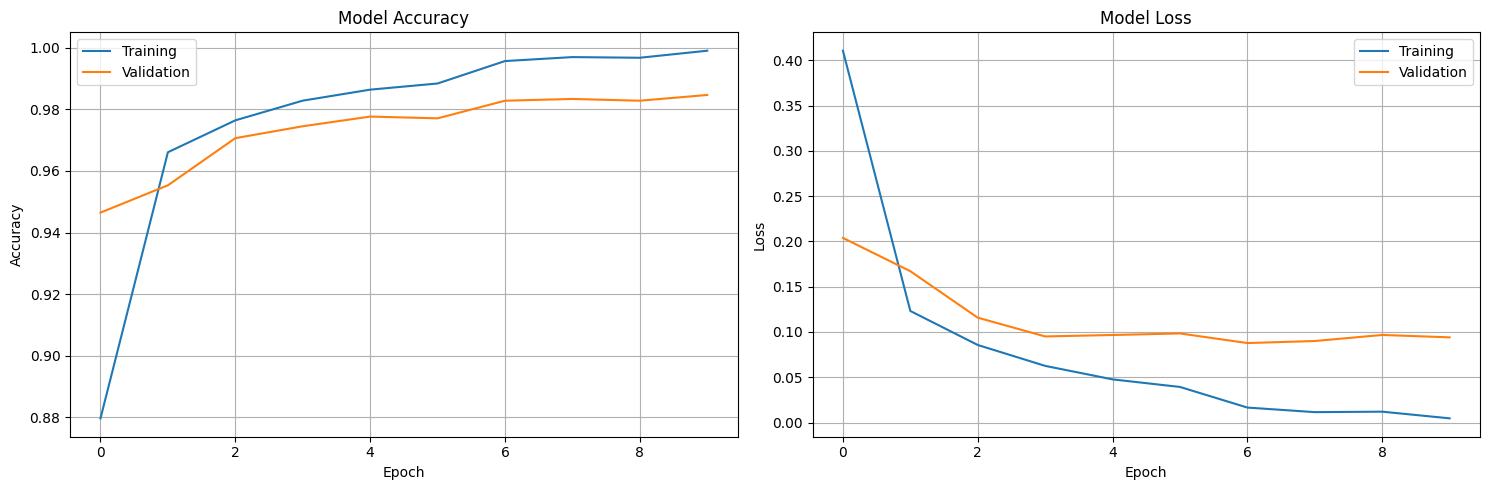

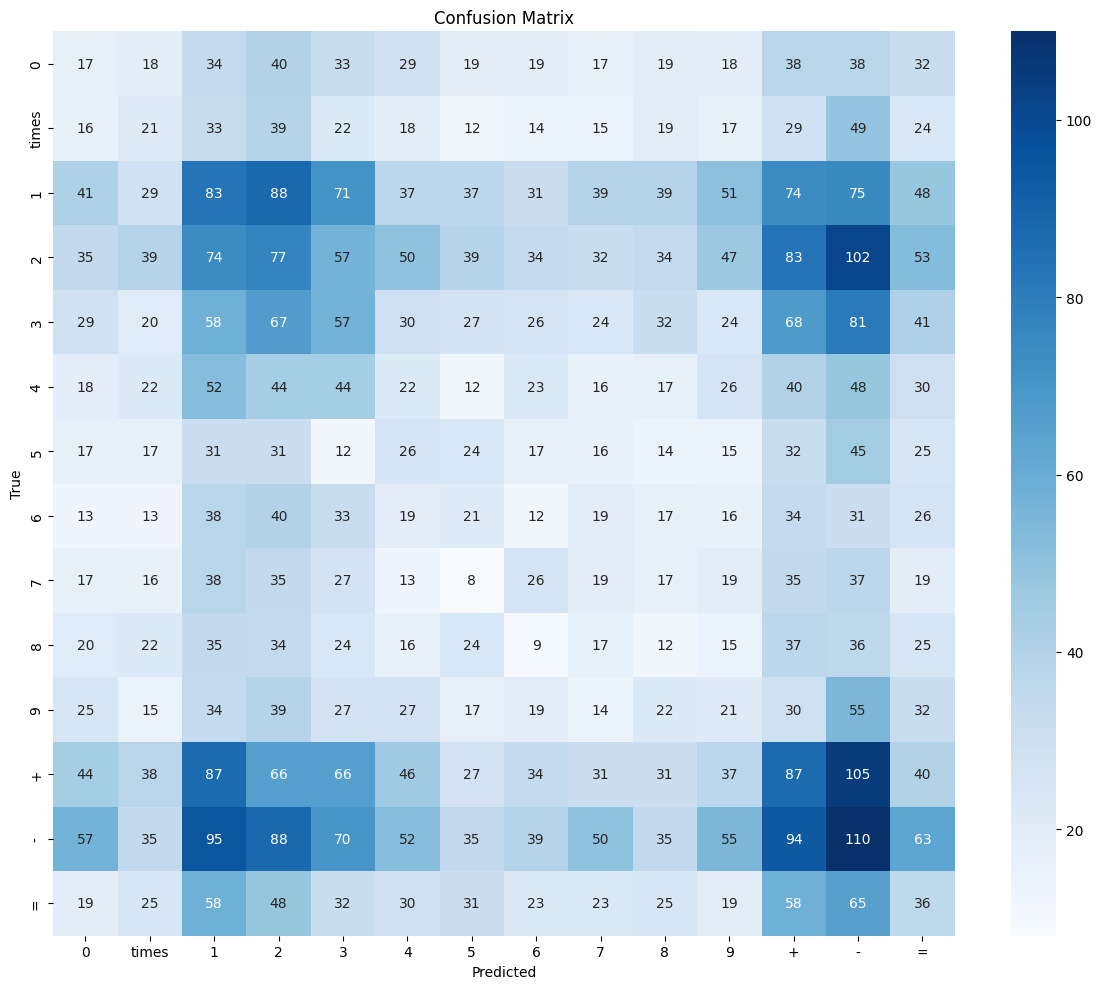

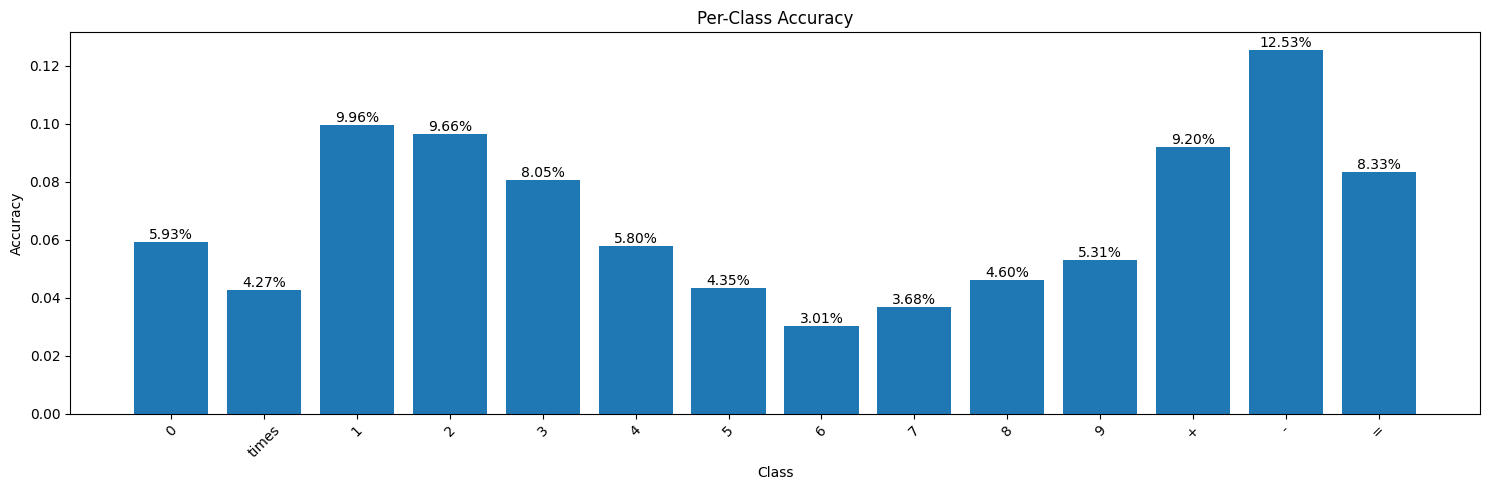

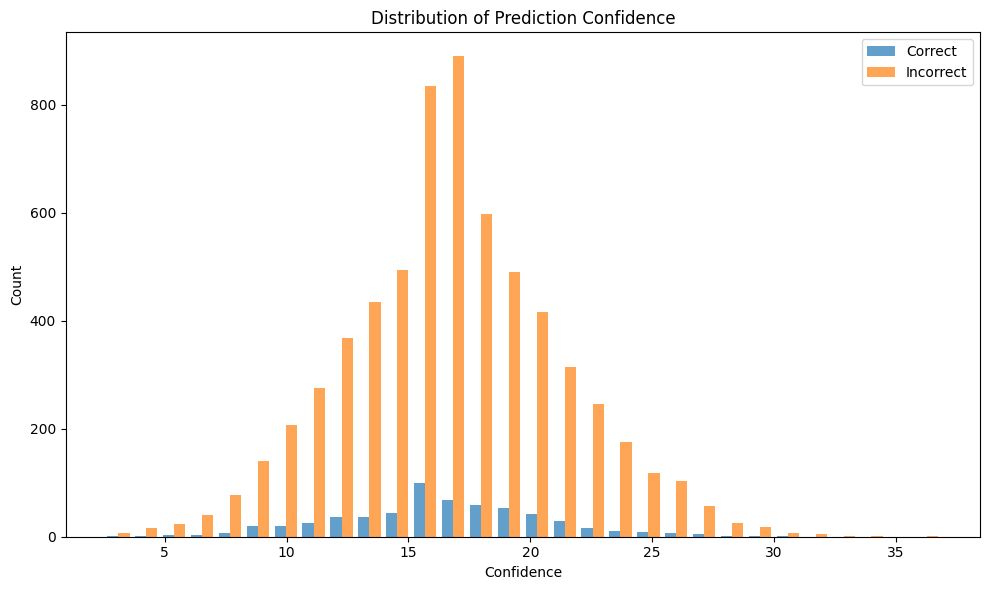

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

def plot_training_curves(history):
    """Plot accuracy and loss curves"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Accuracy
    ax1.plot(history.history['accuracy'], label='Training')
    ax1.plot(history.history['val_accuracy'], label='Validation')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)
    
    # Loss
    ax2.plot(history.history['loss'], label='Training')
    ax2.plot(history.history['val_loss'], label='Validation')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    return fig

def create_confusion_matrix(model, generator, class_names):
    """Create and plot confusion matrix"""
    # Get predictions
    predictions = model.predict(generator)
    y_pred = np.argmax(predictions, axis=1)
    y_true = generator.classes
    
    # Create confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Plot
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    return plt.gcf()

def plot_class_accuracies(model, generator, class_names):
    """Plot per-class accuracy"""
    predictions = model.predict(generator)
    y_pred = np.argmax(predictions, axis=1)
    y_true = generator.classes
    
    # Calculate per-class accuracy
    accuracies = []
    for i in range(len(class_names)):
        mask = y_true == i
        if mask.sum() > 0:  # avoid division by zero
            acc = (y_pred[mask] == i).mean()
            accuracies.append(acc)
        else:
            accuracies.append(0)
    
    # Plot
    plt.figure(figsize=(15, 5))
    bars = plt.bar(class_names, accuracies)
    plt.title('Per-Class Accuracy')
    plt.xlabel('Class')
    plt.ylabel('Accuracy')
    plt.xticks(rotation=45)
    
    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2%}',
                ha='center', va='bottom')
    
    plt.tight_layout()
    return plt.gcf()

def plot_prediction_confidence(model, generator):
    """Plot distribution of prediction confidences"""
    predictions = model.predict(generator)
    confidences = np.max(predictions, axis=1)
    correct = np.equal(np.argmax(predictions, axis=1), generator.classes)
    
    plt.figure(figsize=(10, 6))
    plt.hist([confidences[correct], confidences[~correct]], 
             label=['Correct', 'Incorrect'], 
             bins=30, alpha=0.7)
    plt.title('Distribution of Prediction Confidence')
    plt.xlabel('Confidence')
    plt.ylabel('Count')
    plt.legend()
    plt.tight_layout()
    return plt.gcf()

# Create all plots
training_curves = plot_training_curves(history)
conf_matrix = create_confusion_matrix(model, validation_generator, class_names)
class_acc = plot_class_accuracies(model, validation_generator, class_names)
conf_dist = plot_prediction_confidence(model, validation_generator)

# Save plots
training_curves.savefig('training_curves.png')
conf_matrix.savefig('confusion_matrix.png')
class_acc.savefig('class_accuracies.png')
conf_dist.savefig('confidence_distribution.png')

# Print classification report
predictions = model.predict(validation_generator)
y_pred = np.argmax(predictions, axis=1)
print("\nClassification Report:")
print(classification_report(validation_generator.classes, y_pred, target_names=class_names))

In [16]:
# Get a small batch of validation data and predictions
batch_x, batch_y = next(validation_generator)
batch_pred = model.predict(batch_x)

# Print shapes and few examples
print("Batch input shape:", batch_x.shape)
print("Batch true labels shape:", batch_y.shape)
print("Batch predictions shape:", batch_pred.shape)

# Look at a few examples
for i in range(3):  # Look at first 3 examples
    print(f"\nExample {i+1}:")
    print("True label:", np.argmax(batch_y[i]))
    print("Predicted label:", np.argmax(batch_pred[i]))
    print("Prediction confidence:", np.max(batch_pred[i]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
Batch input shape: (32, 45, 45, 1)
Batch true labels shape: (32, 14)
Batch predictions shape: (32, 14)

Example 1:
True label: 11
Predicted label: 11
Prediction confidence: 15.392326

Example 2:
True label: 2
Predicted label: 4
Prediction confidence: 7.781599

Example 3:
True label: 13
Predicted label: 13
Prediction confidence: 11.03809


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

def plot_training_curves(history):
    """Plot accuracy and loss curves"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Accuracy
    ax1.plot(history.history['accuracy'], label='Training')
    ax1.plot(history.history['val_accuracy'], label='Validation')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)
    
    # Loss
    ax2.plot(history.history['loss'], label='Training')
    ax2.plot(history.history['val_loss'], label='Validation')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    return fig

def get_predictions_and_labels(model, generator):
    """Get aligned predictions and true labels from generator"""
    generator.reset()
    
    all_preds = []
    all_labels = []
    all_pred_probs = []
    
    steps = len(generator)
    for i in range(steps):
        batch_x, batch_y = next(generator)
        batch_pred = model.predict(batch_x, verbose=0)
        
        all_pred_probs.extend(batch_pred)
        all_preds.extend(np.argmax(batch_pred, axis=1))
        all_labels.extend(np.argmax(batch_y, axis=1))
    
    return np.array(all_preds), np.array(all_labels), np.array(all_pred_probs)

def create_confusion_matrix(model, generator, class_names):
    """Create and plot confusion matrix"""
    y_pred, y_true, _ = get_predictions_and_labels(model, generator)
    
    # Create confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Plot
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    return plt.gcf()

def plot_class_accuracies(model, generator, class_names):
    """Plot per-class accuracy"""
    y_pred, y_true, _ = get_predictions_and_labels(model, generator)
    
    # Calculate per-class accuracy
    accuracies = []
    for i in range(len(class_names)):
        mask = y_true == i
        if mask.sum() > 0:  # avoid division by zero
            acc = (y_pred[mask] == i).mean()
            accuracies.append(acc)
        else:
            accuracies.append(0)
    
    # Plot
    plt.figure(figsize=(15, 5))
    bars = plt.bar(class_names, accuracies)
    plt.title('Per-Class Accuracy')
    plt.xlabel('Class')
    plt.ylabel('Accuracy')
    plt.xticks(rotation=45)
    
    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2%}',
                ha='center', va='bottom')
    
    plt.tight_layout()
    return plt.gcf()

def plot_prediction_confidence(model, generator):
    """Plot distribution of prediction confidences"""
    _, y_true, predictions = get_predictions_and_labels(model, generator)
    
    # Get confidence scores and correctness
    confidences = np.max(predictions, axis=1)
    pred_classes = np.argmax(predictions, axis=1)
    correct = pred_classes == y_true
    
    plt.figure(figsize=(10, 6))
    plt.hist([confidences[correct], confidences[~correct]], 
             label=['Correct', 'Incorrect'], 
             bins=30, alpha=0.7)
    plt.title('Distribution of Prediction Confidence')
    plt.xlabel('Confidence')
    plt.ylabel('Count')
    plt.legend()
    plt.tight_layout()
    return plt.gcf()

def print_classification_metrics(model, generator, class_names):
    """Print detailed classification metrics"""
    y_pred, y_true, _ = get_predictions_and_labels(model, generator)
    
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))
    
    # Calculate overall accuracy
    accuracy = np.mean(y_pred == y_true)
    print(f"\nOverall Accuracy: {accuracy:.4f}")

# Create all visualizations
def create_all_visualizations(model, validation_generator, history, class_names):
    """Create and save all visualizations"""
    
    # Create plots
    training_curves = plot_training_curves(history)
    conf_matrix = create_confusion_matrix(model, validation_generator, class_names)
    class_acc = plot_class_accuracies(model, validation_generator, class_names)
    conf_dist = plot_prediction_confidence(model, validation_generator)
    
    # Save plots
    training_curves.savefig('training_curves.png')
    conf_matrix.savefig('confusion_matrix.png')
    class_acc.savefig('class_accuracies.png')
    conf_dist.savefig('confidence_distribution.png')
    
    # Print metrics
    print_classification_metrics(model, validation_generator, class_names)

In [17]:
# Check class distribution in validation generator
from collections import Counter

# Get true labels from generator
validation_labels = validation_generator.classes
print("\nClass distribution in validation data:")
print(Counter(validation_labels))

# Verify class mapping
print("\nClass mapping:")
for class_name, idx in validation_generator.class_indices.items():
    print(f"{class_name}: {idx}")


Class distribution in validation data:
Counter({12: 878, 3: 756, 2: 743, 11: 739, 4: 584, 13: 492, 5: 414, 10: 377, 0: 371, 7: 332, 1: 328, 8: 326, 9: 326, 6: 322})

Class mapping:
0: 0
times: 1
1: 2
2: 3
3: 4
4: 5
5: 6
6: 7
7: 8
8: 9
9: 10
+: 11
-: 12
=: 13


Verified accuracy: 0.9828


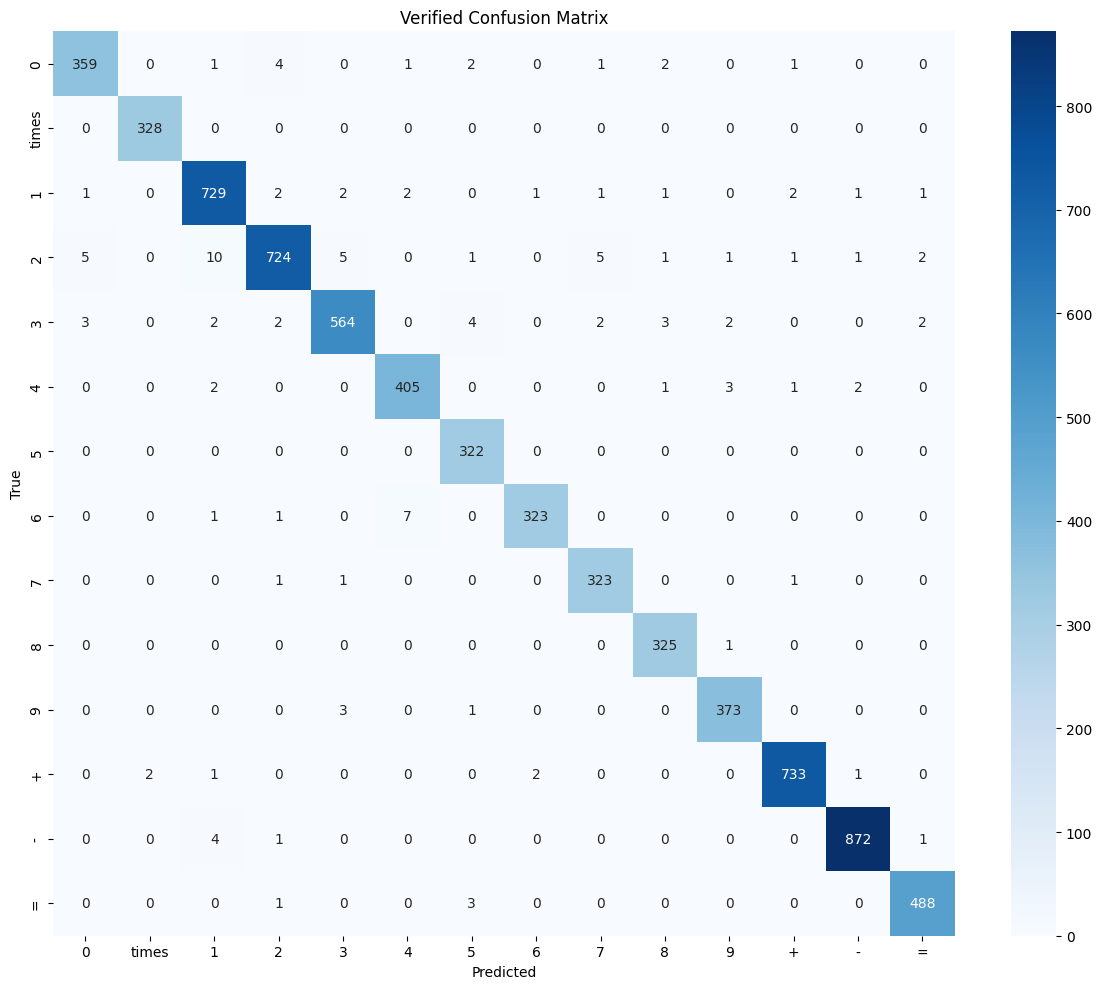

In [18]:
def verify_predictions(model, generator, class_names):
    # Reset generator to start
    generator.reset()
    
    # Collect all predictions and true labels
    all_preds = []
    all_labels = []
    
    steps = len(generator)
    for i in range(steps):
        batch_x, batch_y = next(generator)
        batch_pred = model.predict(batch_x, verbose=0)
        
        all_preds.extend(np.argmax(batch_pred, axis=1))
        all_labels.extend(np.argmax(batch_y, axis=1))
        
    # Calculate accuracy
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    print(f"Verified accuracy: {accuracy:.4f}")
    
    # Create confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    # Plot
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title('Verified Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

verify_predictions(model, validation_generator, class_names)